In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Set device 
device = "cuda:3"

### --- SHARED COMPONENTS (Scheduler & U-Net from previous example) --- ###

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    mean = sqrt_alphas_cumprod_t * x_0
    variance = sqrt_one_minus_alphas_cumprod_t * noise
    
    return mean + variance, noise

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


In [8]:
### --- Part 1: Unconditional DDPM (U-Net Model) --- ###
# This is the standard noise-prediction U-Net. It is trained unconditionally,
# meaning it does not use any class labels during its training.

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t):
        h = self.bn1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bn2(self.relu(self.conv2(h)))
        return self.transform(h)

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256)
        up_channels = (256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        self.output = nn.Conv2d(up_channels[-1], image_channels, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

# --- End of Part 1 ---
# =====================

In [9]:
### --- Part 2: Noise-Aware Classifier --- ###
# This is a simple CNN classifier, but with a crucial modification: it takes the
# timestep 't' as an input. It must be trained on noisy images to learn
# how to classify them at any stage of the diffusion process.

class NoisyClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        time_emb_dim = 32
        
        # Time embedding, similar to the U-Net
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        # Standard CNN architecture
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # The time embedding will be added after this layer
        self.fc1 = nn.Linear(32 * 8 * 8, 256) 
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x, time):
        # Embed the timestep
        t_emb = self.time_mlp(time)
        
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        
        # Add time embedding to the features
        # We need to process the time embedding to match the feature dimensions
        t_emb_transformed = F.interpolate(t_emb.unsqueeze(-1).unsqueeze(-1), size=x.shape[2:], mode='nearest')
        
        x = x + t_emb_transformed
        
        x = x.view(-1, 32 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# --- End of Part 2 ---
# =====================

In [10]:
### --- Main Execution & Training --- ###
if __name__ == '__main__':
    # Hyperparameters
    IMG_SIZE = 32
    BATCH_SIZE = 128
    TIMESTEPS = 1000
    
    # --- Prepare Diffusion Constants ---
    betas = linear_beta_schedule(timesteps=TIMESTEPS)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    # --- Load Data ---
    transforms_mnist = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms_mnist)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    # --- Initialize and Train Models ---
    # For a real application, you would save/load these models.
    # Here, we train them from scratch for a self-contained example.
    
    # 1. Train the Unconditional DDPM
    ddpm_model = Unet().to(device)
    optimizer_ddpm = optim.Adam(ddpm_model.parameters(), lr=0.001)
    criterion_ddpm = nn.MSELoss()
    DDPM_EPOCHS = 15 # Reduced for quicker demonstration

    print("--- Training Unconditional DDPM ---")
    for epoch in range(DDPM_EPOCHS):
        for step, (images, _) in enumerate(tqdm(train_loader, desc=f"DDPM Epoch {epoch+1}")):
            optimizer_ddpm.zero_grad()
            x0 = images.to(device)
            t = torch.randint(0, TIMESTEPS, (x0.shape[0],), device=device).long()
            xt, noise_target = forward_diffusion_sample(x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
            predicted_noise = ddpm_model(xt, t)
            loss = criterion_ddpm(noise_target, predicted_noise)
            loss.backward()
            optimizer_ddpm.step()
        print(f"DDPM Epoch {epoch+1} Loss: {loss.item():.4f}")

    # 2. Train the Noise-Aware Classifier
    classifier_model = NoisyClassifier().to(device)
    optimizer_classifier = optim.Adam(classifier_model.parameters(), lr=0.001)
    criterion_classifier = nn.CrossEntropyLoss()
    CLASSIFIER_EPOCHS = 10 # Reduced for quicker demonstration

    print("\n--- Training Noise-Aware Classifier ---")
    for epoch in range(CLASSIFIER_EPOCHS):
        for step, (images, labels) in enumerate(tqdm(train_loader, desc=f"Classifier Epoch {epoch+1}")):
            optimizer_classifier.zero_grad()
            x0 = images.to(device)
            y = labels.to(device)
            t = torch.randint(0, TIMESTEPS, (x0.shape[0],), device=device).long()
            
            # Create noisy images to train the classifier on
            xt, _ = forward_diffusion_sample(x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
            
            # Predict labels from noisy images
            predicted_labels = classifier_model(xt, t)
            loss = criterion_classifier(predicted_labels, y)
            loss.backward()
            optimizer_classifier.step()
        print(f"Classifier Epoch {epoch+1} Loss: {loss.item():.4f}")



--- Training Unconditional DDPM ---


DDPM Epoch 1: 100%|██████████| 468/468 [00:22<00:00, 20.74it/s]


DDPM Epoch 1 Loss: 0.0249


DDPM Epoch 2: 100%|██████████| 468/468 [00:22<00:00, 20.72it/s]


DDPM Epoch 2 Loss: 0.0220


DDPM Epoch 3: 100%|██████████| 468/468 [00:22<00:00, 20.69it/s]


DDPM Epoch 3 Loss: 0.0206


DDPM Epoch 4: 100%|██████████| 468/468 [00:22<00:00, 20.68it/s]


DDPM Epoch 4 Loss: 0.0263


DDPM Epoch 5: 100%|██████████| 468/468 [00:22<00:00, 20.68it/s]


DDPM Epoch 5 Loss: 0.0225


DDPM Epoch 6: 100%|██████████| 468/468 [00:22<00:00, 20.66it/s]


DDPM Epoch 6 Loss: 0.0176


DDPM Epoch 7: 100%|██████████| 468/468 [00:22<00:00, 20.68it/s]


DDPM Epoch 7 Loss: 0.0194


DDPM Epoch 8: 100%|██████████| 468/468 [00:22<00:00, 20.67it/s]


DDPM Epoch 8 Loss: 0.0228


DDPM Epoch 9: 100%|██████████| 468/468 [00:22<00:00, 20.67it/s]


DDPM Epoch 9 Loss: 0.0172


DDPM Epoch 10: 100%|██████████| 468/468 [00:22<00:00, 20.66it/s]


DDPM Epoch 10 Loss: 0.0200


DDPM Epoch 11: 100%|██████████| 468/468 [00:22<00:00, 20.66it/s]


DDPM Epoch 11 Loss: 0.0170


DDPM Epoch 12: 100%|██████████| 468/468 [00:22<00:00, 20.66it/s]


DDPM Epoch 12 Loss: 0.0165


DDPM Epoch 13: 100%|██████████| 468/468 [00:22<00:00, 20.66it/s]


DDPM Epoch 13 Loss: 0.0166


DDPM Epoch 14: 100%|██████████| 468/468 [00:22<00:00, 20.67it/s]


DDPM Epoch 14 Loss: 0.0188


DDPM Epoch 15: 100%|██████████| 468/468 [00:22<00:00, 20.67it/s]


DDPM Epoch 15 Loss: 0.0236

--- Training Noise-Aware Classifier ---


Classifier Epoch 1: 100%|██████████| 468/468 [00:17<00:00, 27.39it/s]


Classifier Epoch 1 Loss: 1.1038


Classifier Epoch 2: 100%|██████████| 468/468 [00:16<00:00, 27.93it/s]


Classifier Epoch 2 Loss: 1.2069


Classifier Epoch 3: 100%|██████████| 468/468 [00:16<00:00, 28.38it/s]


Classifier Epoch 3 Loss: 1.3176


Classifier Epoch 4: 100%|██████████| 468/468 [00:16<00:00, 28.39it/s]


Classifier Epoch 4 Loss: 1.1682


Classifier Epoch 5: 100%|██████████| 468/468 [00:16<00:00, 27.96it/s]


Classifier Epoch 5 Loss: 0.9915


Classifier Epoch 6: 100%|██████████| 468/468 [00:16<00:00, 28.37it/s]


Classifier Epoch 6 Loss: 1.0803


Classifier Epoch 7: 100%|██████████| 468/468 [00:16<00:00, 28.08it/s]


Classifier Epoch 7 Loss: 1.0627


Classifier Epoch 8: 100%|██████████| 468/468 [00:17<00:00, 27.21it/s]


Classifier Epoch 8 Loss: 1.3573


Classifier Epoch 9: 100%|██████████| 468/468 [00:17<00:00, 26.99it/s]


Classifier Epoch 9 Loss: 1.0531


Classifier Epoch 10: 100%|██████████| 468/468 [00:16<00:00, 27.96it/s]

Classifier Epoch 10 Loss: 1.1952



--- Starting Guided Generation for class: 9 with scale: 2.0 ---


Guided Sampling: 100%|██████████| 1000/1000 [00:05<00:00, 199.41it/s]


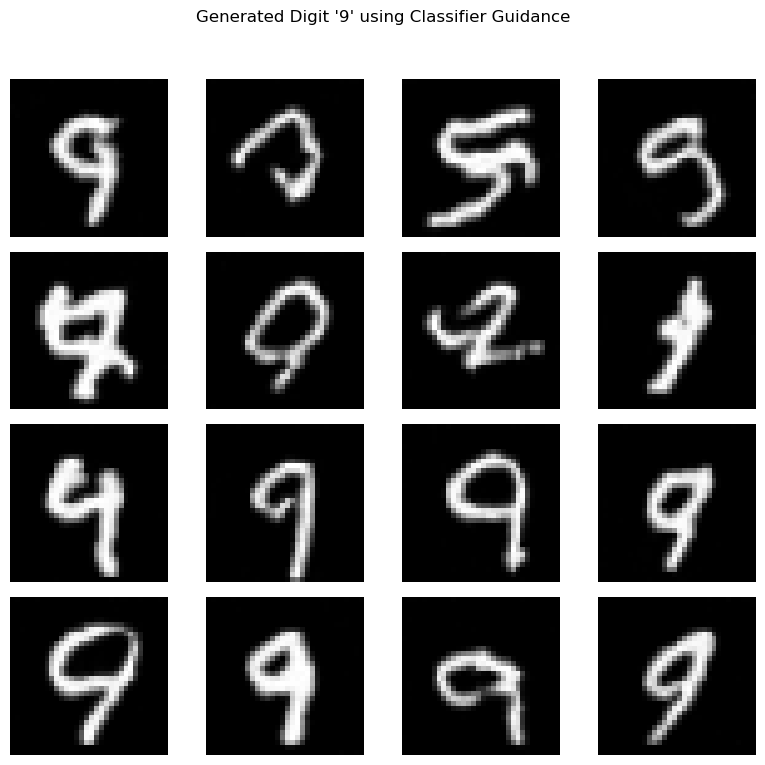

In [12]:
@torch.no_grad()
def guided_sample(target_class, guidance_scale=2.0, num_images=16):
    """
    Part 3: Classifier-Guided Sampling
    Generate `num_images` samples of a given `target_class` by steering
    the DDPM reverse process with gradients from a noise-aware classifier.
    """
    # Log the sampling configuration
    print(f"\n--- Starting Guided Generation for class: {target_class} with scale: {guidance_scale} ---")
    
    # Put both models into evaluation mode (disable dropout/BatchNorm updates)
    ddpm_model.eval()
    classifier_model.eval()

    # 1) Initialize with pure Gaussian noise: x_T ~ N(0, I)
    img = torch.randn((num_images, 1, IMG_SIZE, IMG_SIZE), device=device)
    
    # 2) Create a tensor `y` of the target class for all images
    y = torch.full((num_images,), target_class, device=device, dtype=torch.long)

    # 3) Iterate timesteps from T-1 down to 0
    for i in tqdm(reversed(range(0, TIMESTEPS)), desc="Guided Sampling", total=TIMESTEPS):
        # a) Prepare a tensor of the current timestep index
        t = torch.full((num_images,), i, device=device, dtype=torch.long)
        
        # --- Step 1: Unconditional DDPM prediction ---
        # Predict noise ε_θ(x_t, t) without gradient tracking
        with torch.no_grad():
            predicted_noise = ddpm_model(img, t)  # ε_pred shape: [B, C, H, W]

        # Retrieve schedule scalars for this timestep:
        #   β_t
        betas_t = get_index_from_list(betas, t, img.shape)
        #   √(1 − ᾱ_t)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, img.shape)
        #   1 / √(α_t)
        sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, img.shape)

        # Compute the unconditional reverse mean:
        # μ_uncond = (1/√α_t) * ( x_t − (β_t / √(1−ᾱ_t)) * ε_pred )
        unconditional_mean = sqrt_recip_alphas_t * (
            img - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
        )

        # --- Step 2: Compute classifier gradient for guidance ---
        # We enable gradients on `img` to get ∇_{x_t} log p(y | x_t)
        with torch.enable_grad():
            img_with_grad = img.detach().requires_grad_(True)
            logits = classifier_model(img_with_grad, t)          # shape: [B, num_classes]
            log_probs = F.log_softmax(logits, dim=-1)            # log p_φ(y|x_t)
            selected_log_probs = log_probs[torch.arange(num_images), y]
            # classifier_grad = ∂/∂x_t ∑ log p_φ(y|x_t)
            classifier_grad = torch.autograd.grad(
                selected_log_probs.sum(), img_with_grad
            )[0]  # same shape as img: [B, C, H, W]
        
        # --- Step 3: Combine means with guidance nudge ---
        # Retrieve posterior variance Var[x_{t-1} | x_t]
        posterior_variance_t = get_index_from_list(posterior_variance, t, img.shape)
        # guidance_nudge = guidance_scale * variance * ∇ log p_φ(y|x_t)
        guidance_nudge = guidance_scale * posterior_variance_t * classifier_grad
        
        # μ_guided = μ_uncond + guidance_nudge
        guided_mean = unconditional_mean + guidance_nudge

        # --- Step 4: Sample the next image x_{t-1} ---
        if i == 0:
            # At final step, no additional noise
            img = guided_mean
        else:
            # Inject Gaussian noise: x_{t-1} = μ_guided + √variance * z
            noise = torch.randn_like(img)
            img = guided_mean + torch.sqrt(posterior_variance_t) * noise
    
    # Return models to training mode
    ddpm_model.train()
    classifier_model.train()
    
    # 5) Map pixel range from [-1, 1] back to [0, 1]
    img = (img + 1) * 0.5
    img = img.clamp(0, 1)
    return img

# --- Generate and Plot Images ---
target_digit = 9 # Change this to generate a different digit
generated_images = guided_sample(target_class=target_digit, guidance_scale=2.0)

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Generated Digit '{target_digit}' using Classifier Guidance")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()